## `Speculator`: NMF-based SFH with burst.

`speculator` takes physical parameters and predict PCA coeffs (see `PCA_components_NMF.ipynb`), spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import torch
from torch import Tensor

In [3]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, interp_nan

Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index

In [4]:
#### 10 params

In [5]:
params = np.concatenate([np.load(f'./train_sed_NMF/fsps.NMF.v0.1.theta_unt.seed{i+1}.npy')
                         for i in range(0, 25)])
params = params[:, 1:] # exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)

wave = np.load('./train_sed_NMF/fsps.wavelength.npy')

In [6]:
params.shape[0]

2340000

In [7]:
i_bin = 2

wave_bin = [ 
        (wave >= 1000) & (wave < 2000), 
        (wave >= 2000) & (wave < 3600), 
        (wave >= 3600) & (wave < 5500), 
        (wave >= 5500) & (wave < 7410), 
        (wave >= 7410) & (wave < 60000)
        ][i_bin]
str_wbin = [
        '.w1000_2000', 
        '.w2000_3600', 
        '.w3600_5500', 
        '.w5500_7410', 
        '.w7410_60000' 
        ][i_bin]

transform specs to PCA one by one, avoid memory overflow

In [96]:
# zero_flag = (np.mean(logspec, axis=1) < -40)

# logspec = logspec[~zero_flag]
# params = params[~zero_flag]
# pca_coeff = np.load('./train_sed/fsps.pca_coeffs.npy')[~zero_flag]
# # This zero_flag is SUPER IMPORTANT!!!

In [8]:
fspecs = [f'./train_sed_NMF/fsps.NMF.v0.1.log10spectrum.seed{i+1}{str_wbin}.npy'
                           for i in range(0, 25)]

In [9]:
speculator = Speculator(name='NMF_2', model='NMF', n_parameters=10,
                        pca_filename=f'./train_sed_NMF/best_pca/fsps.NMF.pca_trained{str_wbin}.pkl', 
                        hidden_size=[256, 256, 256, 256])

In [10]:
pca_coeff = []
for file in fspecs:
    pca_coeff.append(speculator.pca.PCA.transform(
        speculator.pca.logspec_scaler.transform(np.load(file, mmap_mode='r'))))
pca_coeff = np.concatenate(pca_coeff)
print(pca_coeff.shape)

(2340000, 50)


In [13]:
speculator.load_data(pca_coeff, params, 
                     params_name=['beta1_sfh', 'beta2_sfh', 'beta3_sfh', 'beta4_sfh', 
                                  'fburst', 'tburst', 'logzsol', 
                                  'dust1', 'dust2', 'dust_index', 'redshift'],
                     val_frac=0.1, batch_size=512, 
                     wave_rest=torch.Tensor(wave[wave_bin]), 
                     wave_obs=torch.Tensor(wave[wave_bin]))

train_ind = speculator.dataloaders['train'].dataset.indices
val_ind = speculator.dataloaders['val'].dataset.indices

In [15]:
speculator.train(n_epochs=1)

Loss = 0.01224 (train), 0.00241 (val), 4.15693 (recon_err): 100%|█████████████████████████████████████| 1/1 [00:36<00:00, 36.47s/epochs]

Epoch: 10 - val Train Loss: 0.0122
Epoch: 10 - val Vali Loss: 0.0024
Recon error: 4.156930923461914


In [71]:
speculator.best_recon_err_epoch

795

In [72]:
speculator.best_loss_epoch

808

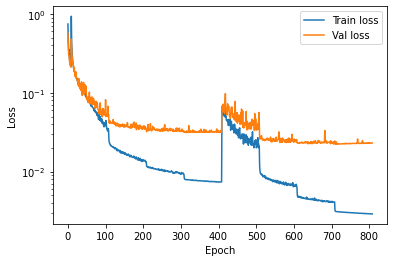

In [69]:
speculator.plot_loss()

In [100]:
outputs = _speculator.network(torch.Tensor(params).to('cuda'))
outputs = _speculator.pca.inverse_transform(
    _speculator.pca_scaler.inverse_transform(outputs), device=_speculator.device)
outputs = _speculator.pca.logspec_scaler.inverse_transform(outputs, device='cuda')

labels = _speculator.pca.inverse_transform(torch.Tensor(pca_coeff).to('cuda'), device='cuda')
labels = _speculator.pca.logspec_scaler.inverse_transform(labels, device='cuda')

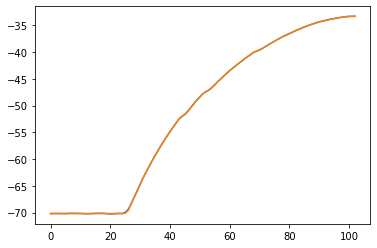

In [101]:
plt.plot(outputs[219].cpu().detach().numpy())
plt.plot(labels[219].cpu().detach().numpy())

In [80]:
from torch.nn import MSELoss

In [81]:
# _specs = speculator.predict_spec(torch.Tensor(params[val_ind]).to('cuda')).cpu().detach().numpy()
# _specs = _speculator.predict_spec(torch.Tensor(params).to('cuda')).cpu().detach().numpy()

In [102]:
outputs = _speculator.network(torch.Tensor(params).to('cuda'))
outputs = _speculator.pca.inverse_transform(
    _speculator.pca_scaler.inverse_transform(outputs), device=_speculator.device)
_logspecs = _speculator.pca.logspec_scaler.inverse_transform(outputs, device='cuda')
_logspecs = _logspecs.detach().cpu().numpy()

labels = _speculator.pca.inverse_transform(torch.Tensor(pca_coeff).to('cuda'), device='cuda')
# labels = _speculator.pca.logspec_scaler.inverse_transform(labels, device='cuda')

In [103]:
MSELoss()(torch.Tensor(_logspecs).to('cuda'), torch.Tensor(logspec).to('cuda'))

tensor(0.0018, device='cuda:0')

In [104]:
MSELoss()(outputs, labels)

tensor(5.4109e-06, device='cuda:0', grad_fn=<MseLossBackward0>)

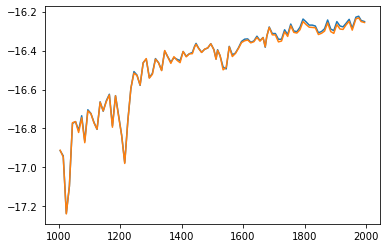

In [105]:
plt.plot(wave[wave_bin], _logspecs[122])
# plt.plot(wave[wave_bin], logspec[val_ind][529])
plt.plot(wave[wave_bin], logspec[122])

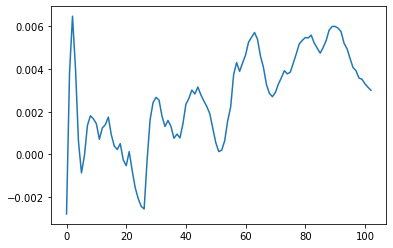

In [106]:
# plt.plot(np.nanmedian(np.log10(_specs) - logspec[val_ind], axis=0))
# plt.plot(np.nanmedian(np.log10(_specs) - logspec, axis=0))
plt.plot(np.nanmedian(_logspecs - logspec, axis=0))

In [107]:
# diff = (10**logspec[val_ind] - _specs) / 10**logspec[val_ind] * 100
# diff = np.abs(10**logspec - _specs) / 10**logspec# * 100
diff = np.abs(10**logspec - 10**_logspecs) / 10**logspec# * 100
# diff = (10**logspec - _specs) / 10**logspec* 100
# diff = (logspec[val_ind] - np.log10(_specs)) / logspec[val_ind] * 100

In [108]:
from scipy.stats import norm

In [89]:
flag = np.nanmean(diff, axis=1) > .3

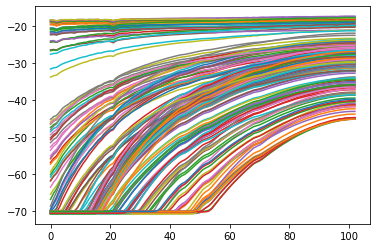

In [90]:
plt.plot(logspec[flag].T)

Text(0.5, 0, 'Wavelength [nm]')

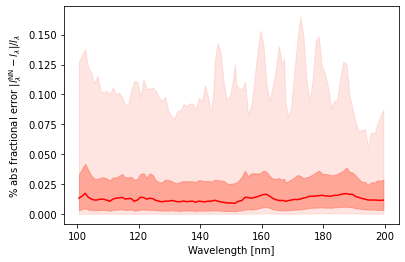

In [109]:
x = wave[wave_bin] / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

plt.ylabel(r'% abs fractional error $|l_{\lambda}^{\mathrm{NN}} - l_{\lambda}|/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

# plt.xscale('log')
# plt.ylim(0, 0.05)

In [229]:
diff = (10**logspec - 10**_logspecs) / 10**logspec* 100

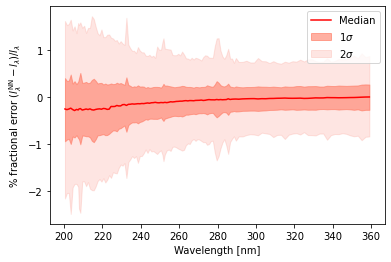

In [230]:
x = wave[wave_bin] / 10
plt.plot(x, np.nanmedian(diff, axis=0), color='r', label='Median')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.nanpercentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

# plt.ylim(-5, 5)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

# plt.hlines(0, 200, 1100, ls='--', color='k')
plt.legend()

# plt.xlim(200, 1100)

In [318]:
from PIL import Image

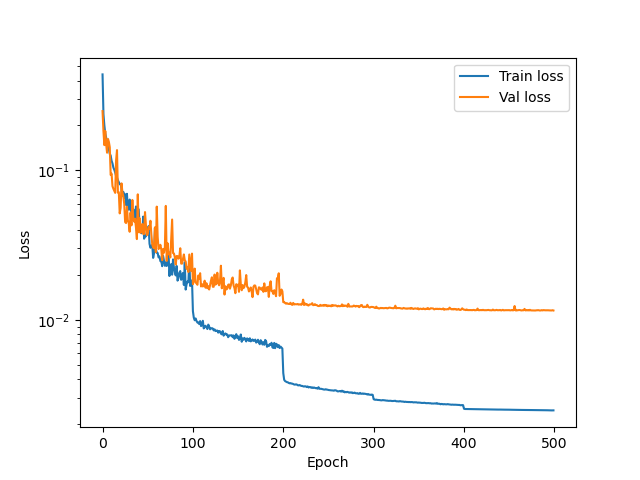

In [20]:
Image.open('./speculator_NMF_4_loss.png')

In [333]:
ls -lhtr

total 3.1G
drwxr-xr-x. 2 jiaxuanl astro 4.0K Oct 30 22:42 train_sed_backup/
-rw-r--r--. 1 jiaxuanl astro 755K Oct 30 22:49 model.pkl
-rw-r--r--  1 jiaxuanl astro 558K Nov  3 13:44 best_model.pth
-rw-r--r--  1 jiaxuanl astro  22M Nov  8 23:25 test.pkl
-rw-r--r--  1 jiaxuanl astro 599K Nov 11 20:46 phot_best_recon_err_model.pkl
-rw-r--r--  1 jiaxuanl astro 600K Nov 11 20:46 phot_best_loss_model.pkl
-rw-r--r--  1 jiaxuanl astro 990K Nov 15 19:54 best_loss_model_nde_nsf.pkl
-rw-r--r--  1 jiaxuanl astro    0 Nov 15 20:56 best_loss_model_KL.pkl
-rw-r--r--  1 jiaxuanl astro 1.1M Nov 28 23:00 best_loss_model_nsf_sinkhorn.pkl
drwxr-xr-x  2 jiaxuanl astro 4.0K Dec  7 21:17 nde_theta_noise_free/
drwxr-xr-x  2 jiaxuanl astro 4.0K Dec  8 00:18 nde_theta_SNR10/
drwxr-xr-x. 2 jiaxuanl astro 4.0K Dec 16 16:42 reference_catalog/
drwxr-xr-x. 2 jiaxuanl astro 4.0K Dec 16 17:57 noise_model/
drwxr-xr-x  2 jiaxuanl astro 4.0K Dec 16 21:47 nde_theta_SNR10_new/
drwxr-xr-x  2 jiaxuanl astro 4.0K Jan 25 16:31 n

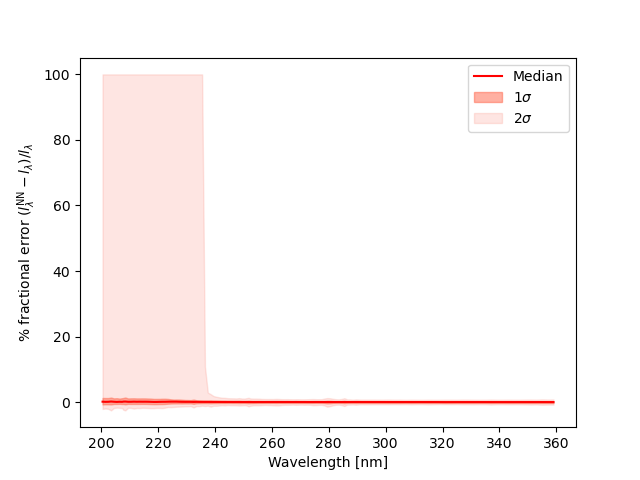

In [334]:
Image.open('./NMF_emulator_.w2000_3600_frac_err.png')